In [16]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [1]:
import matplotlib.pyplot as plt # 맷플롯립 import 하기
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

In [2]:
# 라이브러리 import
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
import matplotlib
import matplotlib.pyplot as plt

In [20]:
# 파일 불러와서 데이터프레임으로

# 구글드라이브 마운트 경로 설정
drive_path = '/content/drive/MyDrive/data/'
# 환율 CSV 파일 로드
data  = pd.read_table(drive_path + 'exchange_rate.csv', sep=",", thousands=',', encoding='CP949')
# 2023 주요지수 CSV 파일 로드
index  = pd.read_table(drive_path + 'index_2023.csv', sep=",", thousands=',')
# 결측치 제거
data  = data.dropna()
index  = index.dropna()
# 일본만 선택해서 테스트
data  = data [data['국가명'] == '일본']
# 날짜를 인덱스로 설정
data['날짜'] = pd.to_datetime(data['날짜'])
data.set_index('날짜', inplace=True)
index['날짜'] = pd.to_datetime(index['날짜'])
index.set_index('날짜', inplace=True)
# 필요한 열 선택
data = data[['매매기준율', 'DAX', 'VN', 'S&P 500', 'KOSPI', 'FTSE', 'DOWJONES', 'NIKKEI', 'NASDAQ']]
index.head()

,DAX,VN,S&P 500,KOSPI,FTSE,DOWJONES,NIKKEI,NASDAQ
날짜,,,,,,,,
2023-01-04,14490.78000,1046.35000,3852.97000,297.60000,7585.19000,33269.77000,25716.86000,10914.80000
2023-01-05,14436.31000,1055.82000,3808.10000,299.50000,7633.45000,32930.08000,25820.80000,10741.22000
2023-01-06,14610.02000,1051.44000,3895.08000,302.70000,7699.49000,33630.61000,25973.85000,11040.35000
2023-01-10,14774.60000,1053.35000,3919.25000,311.80000,7694.49000,33704.10000,26175.56000,11205.78000
2023-01-11,14947.91000,1055.76000,3969.61000,312.70000,7724.98000,33973.01000,26446.00000,11402.52000


In [4]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
train_data = scaled_data[data.index.year <= 2021]
test_data = scaled_data[data.index.year >= 2022]
test_index = data[data.index.year >= 2022]

In [51]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

seq_length = 14   # 과거 60일의 데이터를 기반으로 예측
X_train = create_sequences(train_data, seq_length)
y_train = train_data[seq_length:, :]  # 예측 대상은 모든 칼럼
X_test = create_sequences(test_data, seq_length)

In [52]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(9))  # 출력 레이어 (9개의 칼럼)

model.compile(optimizer='SGD', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
44/44 [==============================] - 2s 9ms/step - loss: 0.2307
Epoch 2/50
44/44 [==============================] - 0s 9ms/step - loss: 0.1372
Epoch 3/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0793
Epoch 4/50
44/44 [==============================] - 0s 9ms/step - loss: 0.0452
Epoch 5/50
44/44 [==============================] - 0s 9ms/step - loss: 0.0294
Epoch 6/50
44/44 [==============================] - 0s 9ms/step - loss: 0.0233
Epoch 7/50
44/44 [==============================] - 0s 9ms/step - loss: 0.0208
Epoch 8/50
44/44 [==============================] - 0s 10ms/step - loss: 0.0195
Epoch 9/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0186
Epoch 10/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0178
Epoch 11/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0172
Epoch 12/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0166
Epoch 13/50
44/44 [========================

In [57]:
# 테스트 데이터의 마지막 시퀀스를 사용하여 미래 예측
last_sequence = X_test[-1]
future_predictions = []

# 미래 예측값 생성
for _ in range(270):  # 예측 기간 설정 (365일)
    next_day_prediction = model.predict(np.array([last_sequence]))
    future_predictions.append(next_day_prediction[0])
    last_sequence = np.roll(last_sequence, shift=-1, axis=0)  # 시퀀스 업데이트
    last_sequence[-1] = next_day_prediction[0]  # 마지막 값 업데이트

# 스케일링 역변환
future_predictions = scaler.inverse_transform(future_predictions)

1/1 [==============================] - 0s 31ms/step


In [54]:
# 데이터프레임 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)  # 생략없이 모든 행, 열 출력

In [58]:
# 지수표기 없이 실수로 표현
pd.options.display.float_format = '{:.5f}'.format
# 예측 결과를 DataFrame으로 변환하고 날짜 인덱스 생성
prediction_dates = pd.date_range(start=test_index.index[-1] + pd.Timedelta(days=1), periods=len(future_predictions))
predicted_df = pd.DataFrame(future_predictions, columns=['매매기준율','DAX','VN','S&P 500','KOSPI','FTSE','DOWJONES','NIKKEI','NASDAQ'], index=prediction_dates)
# prediction_dates
predicted_df.head()

,매매기준율,DAX,VN,S&P 500,KOSPI,FTSE,DOWJONES,NIKKEI,NASDAQ
2022-12-30,1028.36702,13425.31298,1048.85176,3364.52222,338.57263,6963.92328,29229.51460,25614.58336,10405.79005
2022-12-31,1033.17131,13313.60205,1056.85951,3408.25988,335.76803,6992.53336,29107.82817,25365.46479,10204.72387
2023-01-01,1035.25732,13319.07092,1054.45440,3394.14535,335.27167,7011.94354,28931.54364,25086.68303,10143.75601
2023-01-02,1036.92395,13316.77286,1051.65014,3378.62189,334.65173,7032.16342,28788.85592,24855.56549,10079.85161
2023-01-03,1038.32551,13308.30307,1048.43834,3363.59617,333.97001,7051.22548,28654.28690,24659.46349,10012.31133


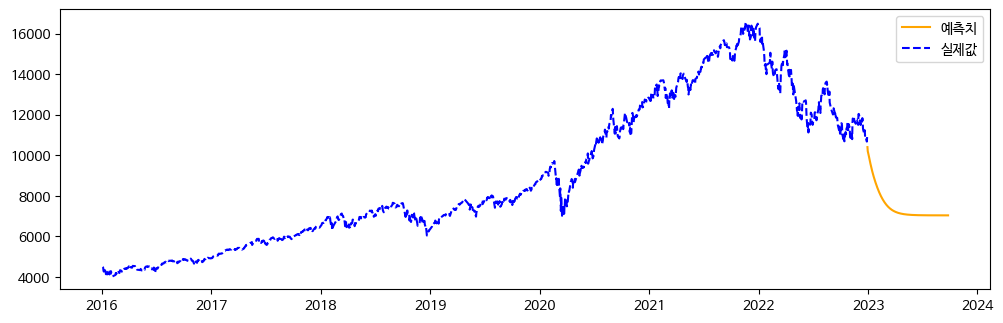

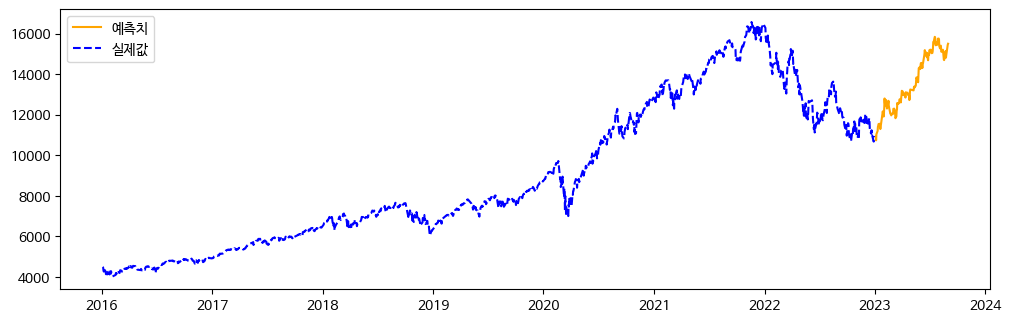

In [59]:
# 예측 매매기준율 시각화

plt.figure(figsize=(12,8))
plt.subplot(212)
plt.plot(predicted_df[['NASDAQ']],'orange', label='예측치')
plt.plot(data[['NASDAQ']],'blue', label='실제값',linestyle = '--')
# plt.xlim([datetime.date(2023, 1, 1), datetime.date(2023, 7, 1)])
plt.legend()
plt.show()
plt.figure(figsize=(12,8))
plt.subplot(212)
plt.plot(index[['NASDAQ']],'orange', label='예측치')
plt.plot(data[['NASDAQ']],'blue', label='실제값',linestyle = '--')
plt.legend()
plt.show()